In [1]:
import random

In [ ]:
random.choices

In [1]:
from eda_imports import *

import pysam
from tqdm import tqdm

import kleat.misc.settings as S
import kleat.misc.utils as U
from kleat.misc.apautils import calc_genome_offset
from kleat.evidence import bridge

from kleat.visaln import visaln

seaborn not found


In [2]:
# DATA_DIR='/projects/btl/zxue/tasrkleat-TCGA-results/tasrkleat-TCGA-analysis-scripts/benchmark-kleat.bk/UHR/C1/tasrkleat-results'
DATA_DIR='../../kleat/'

In [3]:
# c2g_bam = pysam.AlignmentFile(os.path.join(DATA_DIR, './benchmark_transcriptome/HBRC4/c2g.bam'))
# r2c_bam = pysam.AlignmentFile(os.path.join(DATA_DIR, './benchmark_transcriptome/HBRC4/r2c_sorted.bam'))

c2g_bam = pysam.AlignmentFile(os.path.join(DATA_DIR, './benchmark_transcriptome/UHRC1/c2g.bam'))
r2c_bam = pysam.AlignmentFile(os.path.join(DATA_DIR, './benchmark_transcriptome/UHRC1/r2c_sorted.bam'))

In [4]:
# contig_name = 'A0.R100625'
# contig_name = 'E3.L.51'
contig_name = 'E1.L.4362'

In [5]:
for contig in c2g_bam:
    if contig.query_name == contig_name:
#         if contig.reference_name == 'chr16' and contig.is_reverse:
            print(contig.cigarstring)
            break

501M743N169M661N145M1005N94M1712N220M3379N156M1043N78M492N155M101N183M183N508M13S


In [6]:
print(contig.query_name, contig.is_reverse, contig.reference_start)
print(contig.cigarstring)

E1.L.4362 False 23690160
501M743N169M661N145M1005N94M1712N220M3379N156M1043N78M492N155M101N183M183N508M13S


In [43]:
reads = r2c_bam.fetch(contig.query_name)
bdg_read_info = []
for rd in reads:
    if bridge.is_a_bridge_read(rd):
        if contig.is_reverse:
            contig_len = contig.infer_query_length(always=True)
            bdg_read_info.append([
                contig_len - rd.reference_end,
                contig_len - rd.reference_start,
                not rd.is_reverse,
                f'rev({rd.cigarstring})',
                tuple(reversed(rd.cigartuples))
            ])
        else:
            contig_len = contig.infer_query_length(always=True)            
            bdg_read_info.append([                
                rd.reference_start,
                rd.reference_end,
                rd.is_reverse,
                f'{rd.cigarstring}',
                rd.cigartuples
            ])

In [44]:
df_bdg_read = pd.DataFrame(bdg_read_info, columns=['reference_start', 'reference_end', 'is_reverse', 'cigarstring', 'cigartuples'])
df_bdg_read = df_bdg_read.sort_values('reference_start').reset_index(drop=True)

In [45]:
df_bdg_read.shape

(1, 5)

In [46]:
df_bdg_read

,reference_start,reference_end,is_reverse,cigarstring,cigartuples
0,1060,1130,False,70M2S,"[(0, 70), (4, 2)]"


In [11]:
contig_sr = pd.Series(
    [contig.reference_start, contig.reference_end, contig.cigarstring, contig.cigartuples], 
    index=['reference_start', 'reference_end', 'cigarstring', 'cigartuples']
)

In [12]:
contig_sr.to_frame().T

,reference_start,reference_end,cigarstring,cigartuples
0,23690160,23701688,501M743N169M661N145M1005N94M1712N220M3379N156M1043N78M492N155M101N183M183N508M13S,"[(0, 501), (3, 743), (0, 169), (3, 661), (0, 145), (3, 1005), (0, 94), (3, 1712), (0, 220), (3, 3379), (0, 156), (3, 1043), (0, 78), (3, 492), (0, 155), (3, 101), (0, 183), (3, 183), (0, 508), (4, 13)]"


In [13]:
# contig span
contig_sr.reference_end - contig_sr.reference_start

11528

In [47]:
predicted_clv = 23698789

# predicted_clv = 23695410
predicted_clvs = [predicted_clv]

In [48]:
num_skips = visaln.calc_num_skips(contig)
# TODO: turn this into accepting predicted_clvs
df_xlims = visaln.calc_xlim_pairs(contig, predicted_clv)

23690136 - 23690684, covering clv False
23691380 - 23691596, covering clv False
23692210 - 23692402, covering clv False
23693360 - 23693501, covering clv False
23695166 - 23695433, covering clv False
23698765 - 23698968, covering clv True
23699964 - 23700089, covering clv False
23700534 - 23700736, covering clv False
23700790 - 23701020, covering clv False
23701156 - 23701724, covering clv False


Text(0.5,1.02,'E1.L.4362, chr16, (+), clv: 23698789')

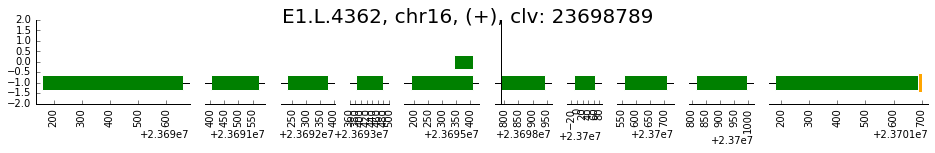

In [49]:
num_subplots = num_skips + 1
fig_height = df_bdg_read.shape[0] * 1.5

fig, axes = plt.subplots(
    1, num_skips + 1, figsize=(16, fig_height), sharey=True, 
    gridspec_kw = {
        'width_ratios':df_xlims.span, 
        'hspace': 0.5
    }
)
if num_subplots == 1:
    axes = [axes]
else:
    axes = axes.ravel()

for ki, row in df_xlims.iterrows():
    ax = axes[ki]
    height = 0.6
    for k, read in df_bdg_read.iterrows():
        cx = visaln.get_abs_start(read)
        cx = visaln.convert_contig2genome_coord(cx, contig)
        cy = k
#         print(cx, end=', ')
        visaln.draw_alignment(ax, cx, cy, read)

    cx = visaln.get_abs_start(contig)
    visaln.draw_alignment(ax, cx, cy=-1, aln=contig)

    ylim = [-2, df_bdg_read.shape[0] + 1]

    for _clv in predicted_clvs:
        ax.plot([_clv, _clv], ylim, color='black')
    ax.set_ylim(ylim)
    print(f'{row.xmin} - {row.xmax}, covering clv {row.xmin <= _clv <= row.xmax}')
    ax.set_xlim(row.xmin, row.xmax)
    
    for tick in ax.get_xticklabels(): tick.set_rotation(90)    
    
    if ki > 0:
        ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    if ki == 0:
        ax.tick_params(top=False, right=False)
    if ki > 0:
        ax.tick_params(top=False, right=False, left=False)
    
strand = '-' if contig.is_reverse else '+'
fig.suptitle(f'{contig.query_name}, {contig.reference_name}, ({strand}), clv: {_clv}', fontsize=20, y =1.02)
# plt.tight_layout()

In [37]:
lele = [(0, 501), (3, 743), (0, 169), (3, 661), (0, 145), (3, 1005), (0, 94), (3, 1712), (0, 220), (3, 3379), (0, 156), (3, 1043), (0, 78), (3, 492), (0, 155), (3, 101), (0, 183), (3, 183), (0, 508), (4, 13)]

In [42]:
s = 0
gnm_offset = 0
for (key, val) in lele:
    gnm_offset += val
    if key == 0:
        s += val
        print(s, s >= 1129, gnm_offset)
    else:
        print(s, s >= 1129, gnm_offset)

501 False 501
501 False 1244
670 False 1413
670 False 2074
815 False 2219
815 False 3224
909 False 3318
909 False 5030
1129 True 5250
1129 True 8629
1285 True 8785
1285 True 9828
1363 True 9906
1363 True 10398
1518 True 10553
1518 True 10654
1701 True 10837
1701 True 11020
2209 True 11528
2209 True 11541
